# Das Vier-Quadranten-Diagramm

In [ ]:
%matplotlib notebook
#Imports

import cv2
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [8]:
# Open diagram
# Original Source = https://de.wikipedia.org/wiki/Verbrauchskennfeld#/media/File:Brake_specific_fuel_consumption.svg
bgra = cv2.imread(r'Muscheldiagramm.png', cv2.IMREAD_UNCHANGED)

sel = bgra[:,:,3]<255

bgra[sel]=[255,255,255,0] #Remove Alpha and replace with whit
bgr = bgra[:,:,0:3] #get BGR (without Alpha)
img = bgr[:,:,::-1] #convert BGR to RGB

# Define colors (used in diagram)
colors_in = np.array(((0, 0, 0), # Maximum, black
                  (0, 0, 255),
                  (0, 0, 191),
                  (0, 0, 127),
                  (0, 0, 63),
                  (0, 255, 0),
                  (0, 191, 0),
                  (0, 127, 0),
                  (0, 63, 0),
                  (255, 0, 0),
                  (191, 0, 0),
                  (127, 0, 0),
                  (63, 0, 0),
                  (63, 63, 63),
                  (127, 127, 127),
                  (191, 191, 191)),
                  np.uint8)

#colors_out

color_moment = np.array((0, 0, 0))
color_good = np.array((113, 167, 2))
color_bad = np.array((167, 110, 2))

ratio = np.arange(0,1,1/(colors_in.shape[0]-1))
colors_bad = np.tile(color_bad, (colors_in.shape[0]-1,1))
colors_out = np.tile(color_good, (colors_in.shape[0],1))

colors_out[0] = color_moment
colors_out[1:] = (colors_out[1:].T*(1-ratio) + colors_bad.T*ratio).T

#Std matplotlib colors
cmap = plt.get_cmap("tab10")

#Some parameters
g = 9.81
rhol = 1.2

#Scale for better readability
scale = 6

In [ ]:
def plot_scaled(ax, x, y, scale=1, quadrant = 1, i=1, **kwargs):
    
    signs = ((1,-1,-1,1),(1,1,-1,-1))
    scale = ((scale, 1, 1, scale),(1, 1, scale, scale))
        
    if quadrant == 3:
        x, y = y, x
    
    x = signs[0][quadrant-1]*scale[0][quadrant-1]*x/i
    y = signs[1][quadrant-1]*scale[1][quadrant-1]*y*i
    
    return ax.plot(x, y, **kwargs)
    
    
def sort_points(indices):
    """Finds always the next closest point and sorts array"""
    
    ind = np.empty(shape=indices.shape, dtype=np.float)
    ind[1:,:] = np.nan
        
    for i in range(1,len(indices)-1):
        if not np.isnan(indices[i])[0]:
            row = indices[i]
            i += 1
            
            dist=np.linalg.norm(indices[i+1:,:]-row, axis=1)
            
            if dist != []:

                dist
                j = np.argmin(dist)


                found_ind = np.where(dist==dist[j])[0]+i+1

                if len(found_ind)>0:
                    ind[i] = indices[found_ind[0]]
                    for f in found_ind:
                        indices[f] = np.nan
                        
    ind_ret = np.asarray(ind[~np.isnan(ind).any(axis=1)], dtype=np.int32)
    
    return ind_ret[1:,:]

# Note
# y-axis top to bottom
# x-axis left to right

def plot_lines(ax, lines, colors, linewidth=1, **kwargs):
    line_objs = []
    for i, l in enumerate(lines):
        for ele in l:
            obj, = plot_scaled(ax, np.asarray(ele[:2]), np.asarray(ele[2:]), color=colors[i]/255, linewidth=linewidth, **kwargs)
            line_objs.append(obj)
            
    return line_objs
    

def get_color(img, col):
    dist = (abs(img[:,:].astype(dtype=float)-col) <= 5)
    bol_close = dist.all(axis=2)
    indices = np.asarray(np.where(bol_close), dtype=float).transpose()
    return indices

def find_upper_boundary_M(img):
    
    indices = get_color(img, colors_in[0])
    
    maxM = np.empty(shape=img.shape[1], dtype=np.float)
    
    for px in range(img.shape[1]): # find max y-position for each column of image
        ypxs = np.where(indices[:,1]==px)
        ylim = int(indices[ypxs, 0].max())
        maxM[px] = img.shape[0]-1-ylim
        img[:ylim,px,:] = (255, 255, 255)
        
        
    return maxM
    
def find_contour(indices,rmax=20, rmin=7):
    
    yoffset = img.shape[0]-1
    lines = []
    def find_closest(pos=None, pprev=None):
        
        if pos is None:
            found = np.where(indices[:,0]>0)[0][0]
            pos = found
        
        p = indices[pos,:].copy()
        indices[pos,:] = -200
        
        # Remove closest
        dist = np.linalg.norm(indices - p, axis=1)
        indices[dist<= rmin,:] = -200
        
        # Check if close by still points
        dist = np.linalg.norm(indices - p, axis=1)
        dmin = dist.min()
        if dmin <= rmax:
            pos = np.where(dist==dmin)[0][0]
            pnext = indices[pos,:].copy()
            add_line(p, pnext)
            plast = find_closest(pos=pos, pprev=p.copy())
            
            if (pprev is None) & (np.linalg.norm(plast-p) < rmax):
                add_line(p, plast)
                
        else:
            plast = p
            
        # Check if close by still points
        dist = np.linalg.norm(indices - p, axis=1)
        dmin = dist.min()
        if dmin <= rmax:
            pos = np.where(dist==dmin)[0][0]
            pnext = indices[pos,:].copy()
            d = np.linalg.norm(pnext - p)
            
            if (d < rmax) & (pprev is None or d < np.linalg.norm(pnext-pprev)):

                add_line(p, pnext)
                plast = find_closest(pos=pos)
            
        return plast.copy()
    
    def add_line(pstart, pend):
        lines.append(np.array((pstart[1], pend[1], yoffset-pstart[0], yoffset-pend[0])))
    
    def check_if_finished():
        return (indices[:,0]>=0).any()
    
    while check_if_finished():
        find_closest()
        
    return lines

def find_all_contours():
    indices_rawx = get_color(img, colors_in[0])
    lines = [find_contour(indices_rawx.copy(), rmax=150, rmin=15)]

    for col in colors_in[1:]:

        indices = get_color(img, col)
        lines.append(find_contour(indices))
        
    return lines

# Offset x direction = 1000+425.2/2
# End x direction =6829/2
# deltax = 6829/2-425.2/2
def rescale_diagramm(lines):
    # x-Offset/Delta
    xoffset = 1000+425.2/2
    deltax = 6829/2-425.2/2
    scalex = deltax/img.shape[1]
    
    def adj_x(vec):
        return (xoffset + vec*scalex)/60*2*math.pi #Scale and convert rpm to rad/s
    
    # Calculate y-Scale
    P = 70000 #70kW
    omega = adj_x(np.arange(img.shape[1]))
    scaley = P/(omega*maxM_unscaled).max()
    
    # Scale x and y
    for i, l in enumerate(lines):
        for j, ele in enumerate(l):
            lines[i][j][:2] = adj_x(ele[:2])
            lines[i][j][2:] = scaley*ele[2:]

maxM_unscaled = find_upper_boundary_M(img)

lines_unscaled = find_all_contours()
lines = copy.deepcopy(lines_unscaled) #necessary, ---.copy() still has same lists handles stored
rescale_diagramm(lines)

def plot_engine(ax, show_axis=True, only_tor=False, linewidth=1, **kwargs):
    tor = plot_lines(ax, lines[0:1], colors_out, linewidth=linewidth, **kwargs)
    
    if only_tor:
        return tor
    
    line_objs_diagram = plot_lines(ax, lines[1:], colors_out[1:], linewidth=0.7, **kwargs)
    if show_axis:
        plt.xlabel('Rotationsgeschwindigkeit in $\mathrm{\dfrac{rad}{s}}$')
        plt.ylabel('Moment in $\mathrm{Nm}$')
        
    return line_objs_diagram, tor

<IPython.core.display.Javascript object>


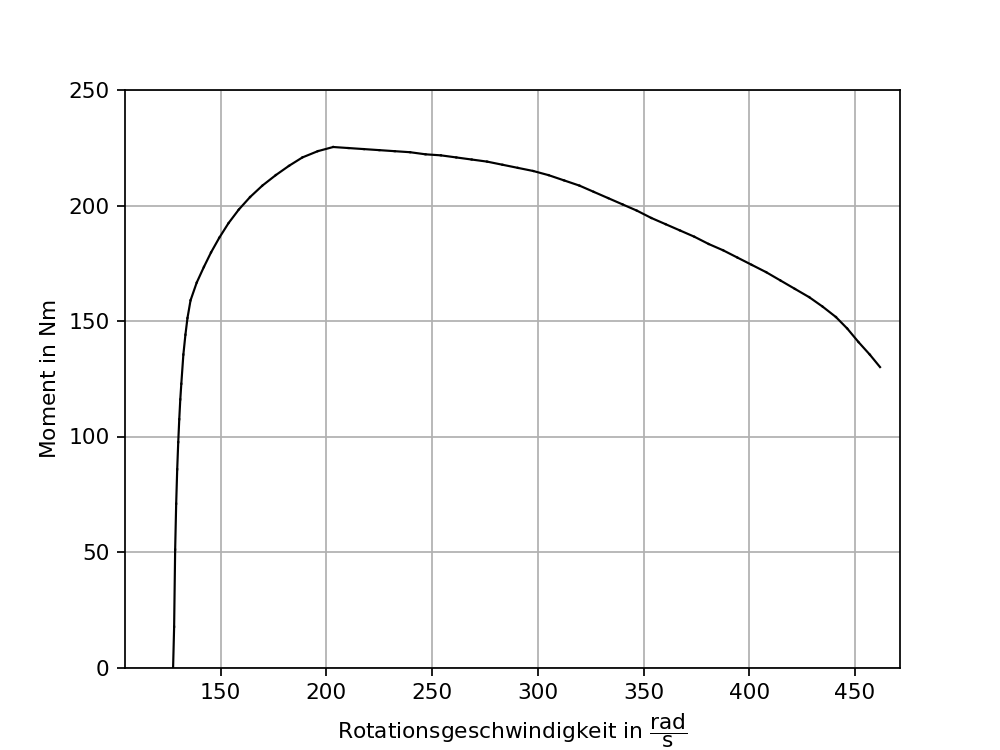

interactive(children=(Checkbox(value=False, description='Muscheldiagramm'), Checkbox(value=False, description=…

In [4]:
def engine_plot():

    fig_diagram = plt.figure()
    ax_diagram = fig_diagram.add_subplot(111)

    line_objs_diagram, m_objs = plot_engine(ax_diagram)
    line_objs_power = []
    text_objs_power = []
    xpoints = np.arange(50, 5500, 50)*2*math.pi/60

    for p in [10000, 30000, 50000, 70000, 90000]:
        obj, = plt.plot(xpoints, p/xpoints, color = 'grey', linewidth=0.5, linestyle='None')
        line_objs_power.append(obj)
        obj = plt.text(4500/60*2*math.pi+5, p/(4500/60*2*math.pi), str(int(p/1000)) + ' kW', visible=False, horizontalalignment='left')
        text_objs_power.append(obj)

    res, = plt.plot(1,1)

    plt.xlim(1000/60*2*math.pi, 4500/60*2*math.pi)
    plt.ylim(0, 250)
    plt.grid(True)
    ax = plt.gca()

    prevP = [False]

    data = []
    for line in m_objs + line_objs_diagram +line_objs_power:
        data.append([line.get_xdata(), line.get_ydata()])

    def toggle_visibility(onoff, line_objs, text_objs = [], alsLeistung=False):

        if onoff:
            for line in line_objs:
                line.set_linestyle('-')

            if not alsLeistung:
                for text in text_objs:
                    text.set_visible(True)
            else:
                for text in text_objs:
                    text.set_visible(False)
        else:
            for line in line_objs:
                line.set_linestyle('None')
            for text in text_objs:
                text.set_visible(False)
        fig_diagram.canvas.draw()

    def change_plot(Muscheldiagramm, line_objs_dia, IsoLeistung, line_objs_iso, text_objs, m_objs, alsLeistung, prevP, data):
        if prevP[0] != alsLeistung:
            prevP[0] = alsLeistung

            c=0        
            for line in m_objs + line_objs_dia + line_objs_iso:
                if alsLeistung:
                    ax.set_ylim(0, 80)
                    line.set_ydata(data[c][1]*data[c][0]/1000)
                    ax.set_ylabel('Leistung in $\mathrm{kW}$')
                else:
                    ax.set_ylim(0, 250)
                    line.set_ydata(data[c][1])
                    ax.set_ylabel('Moment in $\mathrm{Nm}$')

                c += 1

        toggle_visibility(Muscheldiagramm, line_objs_dia)
        toggle_visibility(IsoLeistung, line_objs_iso, text_objs, alsLeistung)

    widgets.interact(change_plot, Muscheldiagramm=False, line_objs_dia=widgets.fixed(line_objs_diagram), line_objs_iso=widgets.fixed(line_objs_power), alsLeistung=False, text_objs=widgets.fixed(text_objs_power), m_objs=widgets.fixed(m_objs), IsoLeistung=prevP[0], prevP=widgets.fixed(prevP), data=widgets.fixed(data))
    
engine_plot()

## Widerstände berechnen

Radwiderstand:

$F_\mathrm{W,R}=f_\mathrm{r} \cdot m \cdot g$

Steigungswiderstand:

$F_\mathrm{W,St} = \sin(\alpha) \cdot m \cdot g \approx \alpha \cdot m \cdot g$

Luftwiderstand:

$F_\mathrm{W,L}=\dfrac{1}{2}c_\mathrm{w} \cdot A \cdot \rho_{\mathrm{L}} \cdot v_\mathrm{rel}^2$

Beschleunigungswiderstand:

$F_\mathrm{W,Be}= m \cdot a$

<IPython.core.display.Javascript object>


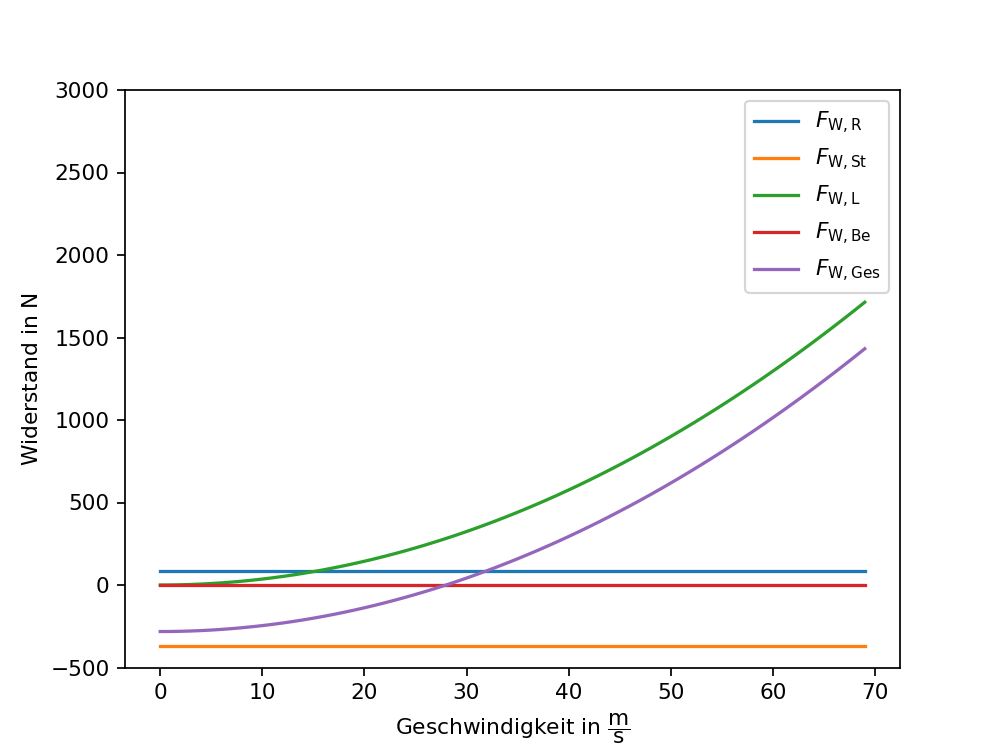

interactive(children=(FloatSlider(value=0.007, description='fr', max=0.015, step=0.001), IntSlider(value=1250,…

In [5]:
def FWR(v, fr, m):
    return np.ones(shape=v.shape)*fr*m*g

def FWS(v, alpha, m):
    return np.ones(shape=v.shape)*alpha*m*g

def FWL(v, cwA, vwind):
    vrel = (v-vwind)
    return 1/2*rhol*cwA*vrel*vrel*np.sign(vrel)

def FWA(v, a, m):
    return np.ones(shape=v.shape)*a*m

def draw_resistance(ax, v, m=1400, vrel=0, cwA=0.6, a=0, alpha=0, fr=0.01, only_tot=False, scale=1, quadrant=1, **kwargs):

    fwr_vals = FWR(v, fr, m)
    fws_vals = FWS(v, alpha, m)
    fwl_vals = FWL(v, cwA, vrel)
    fwa_vals = FWA(v, a, m)
    
    if not only_tot:
        hFWR, = plot_scaled(ax, v, fwr_vals, scale=scale, quadrant=quadrant, **kwargs)
        hFWS, = plot_scaled(ax, v, fws_vals, scale=scale, quadrant=quadrant, **kwargs)
        hFWL, = plot_scaled(ax, v, fwl_vals, scale=scale, quadrant=quadrant, **kwargs)
        hFWA, = plot_scaled(ax, v, fwa_vals, scale=scale, quadrant=quadrant, **kwargs)
    
    hFT, = plot_scaled(ax, v, fwr_vals+fws_vals+fwl_vals+fwa_vals, scale=scale, quadrant=quadrant, **kwargs)
    if only_tot:
        return hFT
    else:
        return hFWR, hFWS, hFWL, hFWA, hFT

def resistance_plot():

    v = np.arange(0, 70, 1)

    fig_res = plt.figure()
    ax_res = fig_res.add_subplot(111)

    hFWR, hFWS, hFWL, hFWA, hFT = draw_resistance(ax_res, v)

    plt.xlabel('Geschwindigkeit in $\mathrm{\dfrac{m}{s}}$')
    plt.ylabel('Widerstand in $\mathrm{N}$')

    plt.legend(['$F_\mathrm{W,R}$', '$F_\mathrm{W,St}$', '$F_\mathrm{W,L}$', '$F_\mathrm{W,Be}$', '$F_\mathrm{W,Ges}$'])

    plt.ylim(-500, 3000)

    def F(fr, m, cwA, vwind, a, alpha, v, als_Leistung, ax):
        fwr_vals = FWR(v, fr, m)
        fws_vals = FWS(v, alpha, m)
        fwl_vals = FWL(v, cwA, vwind)
        fwa_vals = FWA(v, a, m)
        fges = fwr_vals+fws_vals+fwl_vals+fwa_vals

        if als_Leistung:
            fwr_vals *= v/1000
            fws_vals *= v/1000
            fwl_vals *= v/1000
            fwa_vals *= v/1000
            fges *= v/1000
            plt.ylabel('Widerstandsleistung in $\mathrm{kW}$')
            plt.legend(['$P_\mathrm{W,R}$', '$P_\mathrm{W,St}$', '$P_\mathrm{W,L}$', '$P_\mathrm{W,Be}$', '$P_\mathrm{W,Ges}$'])


            ax.set_ylim(-10, 100)
        else:
            plt.ylabel('Widerstand in $\mathrm{N}$')
            plt.legend(['$F_\mathrm{W,R}$', '$F_\mathrm{W,St}$', '$F_\mathrm{W,L}$', '$F_\mathrm{W,Be}$', '$F_\mathrm{W,Ges}$'])
            ax.set_ylim(-500, 3000)

        hFWR.set_ydata(fwr_vals)
        hFWS.set_ydata(fws_vals)
        hFWL.set_ydata(fwl_vals)
        hFWA.set_ydata(fwa_vals)
        hFT.set_ydata(fges)



        #ax = plt.gca()
        #ax.relim()
        #ax.autoscale_view()
        #plt.draw()

    _ = widgets.interact(F, fr=(0,.015, 0.001), m=(900, 1600, 50), cwA=(0.3, 1, 0.05), vwind=(-20, 20, 1), a=(-5, 5, 0.25), alpha=(-0.05, 0.05, 0.01), v=widgets.fixed(v), als_Leistung=False, ax=widgets.fixed(ax_res))

resistance_plot()

<IPython.core.display.Javascript object>


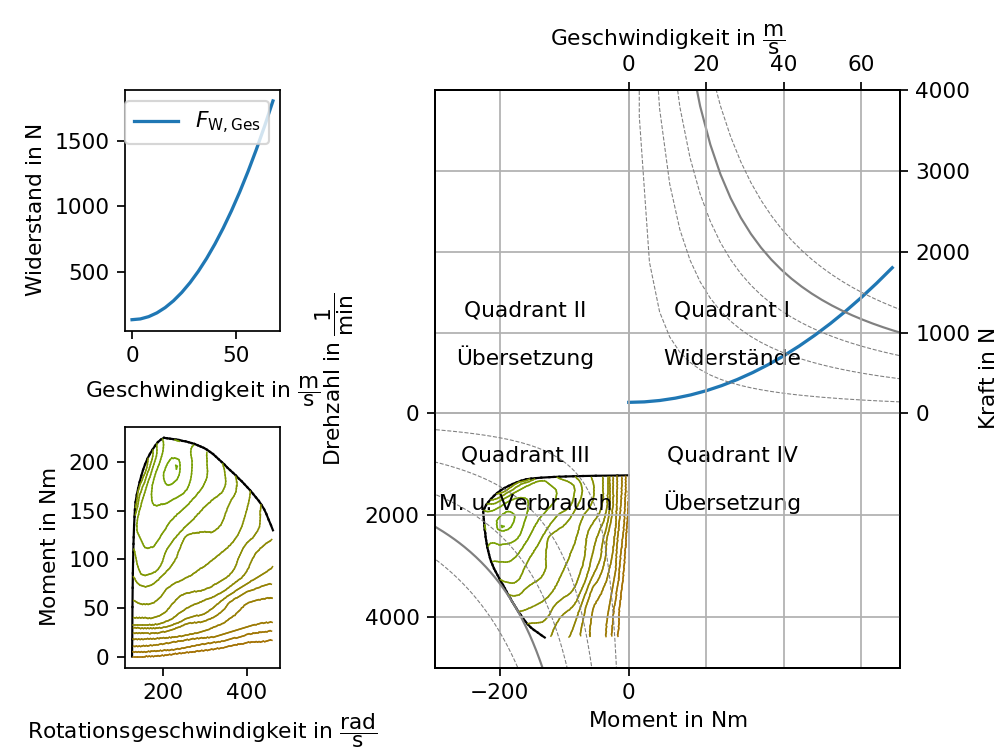

In [12]:
def create_ax(ax_com_us):

    xb, xe = -300, 70
    yb, ye = -5000/60*2*math.pi, 4000

    plt.ylim(yb*scale, ye)
    plt.xlim(xb, xe*scale)

    
    ax_com_us.yaxis.tick_right()
    ax_com_us.yaxis.set_label_position('right')
    
    plt.xlabel('Moment in $\mathrm{Nm}$')
    plt.ylabel('Kraft in $\mathrm{N}$')
    
    int_ax=ax_com_us.twiny()
    plt.xlabel('Geschwindigkeit in $\mathrm{\dfrac{m}{s}}$')
    int_ax.grid(True)
    ax_com_sc = int_ax.twinx()
    ax_com_sc.yaxis.tick_left()
    plt.ylabel('Drehzahl in $\mathrm{\dfrac{1}{min}}$')
    ax_com_sc.yaxis.set_label_position('left')
    ax_com_sc.xaxis.set_label_position('bottom')
    #ax_com_sc.invert_yaxis()

    fac = 60/(2*math.pi)

    plt.ylim(-yb*fac, -ye/scale*fac)
    plt.xlim(xb/scale, xe)


    if True:
        ticks = ax_com_us.get_yticks()
        ax_com_us.set_yticks(ticks[ticks>=0])
        ticks = ax_com_us.get_xticks()
        ax_com_us.set_xticks(ticks[ticks<=0])

        ticks = ax_com_sc.get_yticks()
        ax_com_sc.set_yticks(ticks[ticks>=0])
        ticks = ax_com_sc.get_xticks()
        ax_com_sc.set_xticks(ticks[ticks>=0])

    plt.ylim(-yb*fac, -ye/scale*fac)
    plt.xlim(xb/scale, xe)
    ax_com_us.set_xlim(xb, xe*scale)
    ax_com_us.set_ylim(yb*scale, ye)

    ax_com_us.grid(True, axis='both')
    ax_com_sc.grid(True, axis='both')

#Quadranten
def create_quadrants(ax, x, y):
    t_qua = []
    obj = ax.text(x, y, 'Quadrant I', ha='center')
    t_qua.append(obj)
    obj = ax.text(x, 0.5*y, 'Widerstände', ha='center')
    t_qua.append(obj)
    obj = ax.text(-x, y, 'Quadrant II', ha='center')
    t_qua.append(obj)
    obj = ax.text(-x, 0.5*y, 'Übersetzung', ha='center')
    t_qua.append(obj)
    obj = ax.text(-x, -0.5*y, 'Quadrant III', ha='center')
    t_qua.append(obj)
    obj = ax.text(-x, -y, 'M. u. Verbrauch', ha='center')
    t_qua.append(obj)
    obj = ax.text(x, -0.5*y, 'Quadrant IV', ha='center')
    t_qua.append(obj)
    obj = ax.text(x,-y, 'Übersetzung', ha='center')
    t_qua.append(obj)
    
    return t_qua
    
def draw_power(ax, power, xpoints, linestyle='--', linewidth=0.5):

    h_power = []

    #Draw power
    for p in power:
        obj, = plot_scaled(ax, xpoints, p/xpoints, scale=scale, quadrant = 1, color = 'grey', linewidth=linewidth, linestyle=linestyle)
        h_power.append(obj)
        obj, = plot_scaled(ax, xpoints, p/xpoints, scale=scale, quadrant = 3, color = 'grey', linewidth=linewidth, linestyle=linestyle)
        h_power.append(obj)

def quadrants_plot():        

    xpoints = np.arange(50, 5500, 50)*2*math.pi/60
    fig = plt.figure()
    v=np.arange(0, 70, 4)

    grid = plt.GridSpec(2, 3, hspace=0.4, wspace=1)

    xpoints = np.arange(1, 5500, 25)*2*math.pi/60

    #Resistance
    ax_res = fig.add_subplot(grid[0, 0])
    draw_resistance(ax_res, v, only_tot=True)
    plt.xlabel('Geschwindigkeit in $\mathrm{\dfrac{m}{s}}$')
    plt.ylabel('Widerstand in $\mathrm{N}$')
    plt.legend(['$F_\mathrm{W,Ges}$'])

    #Engine
    ax_eng = fig.add_subplot(grid[1, 0])
    plot_engine(ax_eng, show_axis=True, scale=1, quadrant=1)
    #plot_engine(ax)

    ax_com_us = fig.add_subplot(grid[:, 1:]) #axis complete unscaled
    #ax = fig.add_subplot(2,3,(2,3,5,6))

    create_ax(ax_com_us)
    plot_engine(ax_com_us, show_axis=False, scale=scale, quadrant=3)
    draw_resistance(ax_com_us, v, only_tot=True, scale=scale, quadrant=1)
    t_qua = create_quadrants(ax_com_us, 160, 1200)

    power = [10000, 30000, 50000, 90000]
    draw_power(ax_com_us, power, xpoints)
    draw_power(ax_com_us, [70000], xpoints, linewidth=1, linestyle='-')
    
quadrants_plot()

<IPython.core.display.Javascript object>


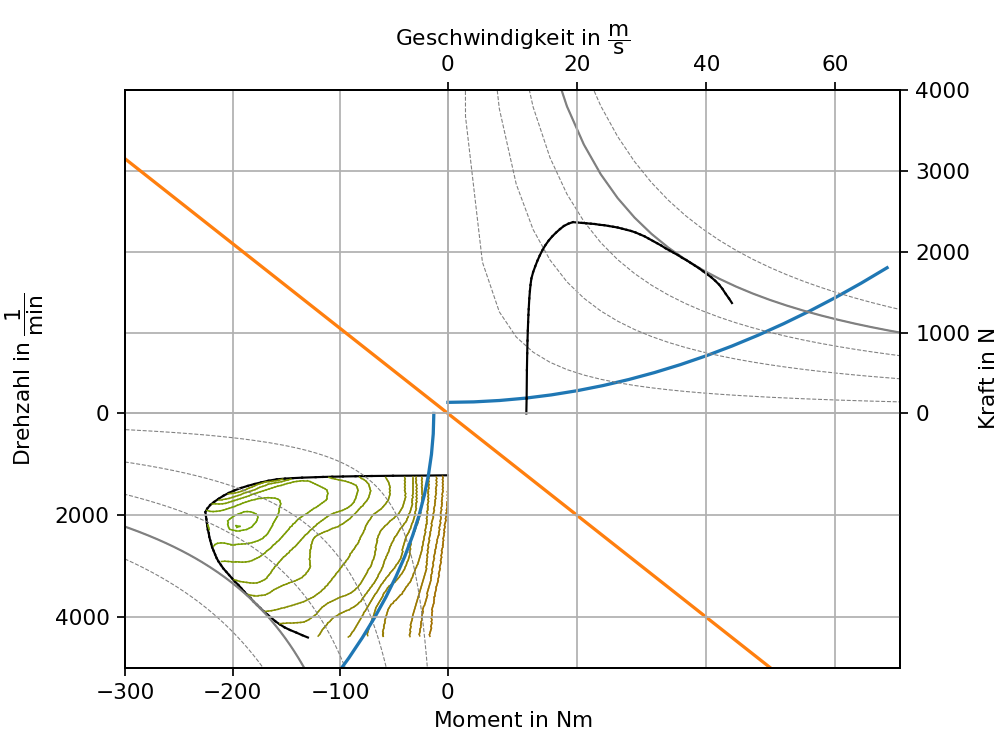

interactive(children=(FloatSlider(value=10.0, description='iges', max=20.0, min=1.0, step=0.5), Output()), _do…

In [15]:
def transmission_plot():

    fig = plt.figure()
    v=np.arange(0, 70, 4)

    grid = plt.GridSpec(2, 3, hspace=0.4, wspace=1)

    xpoints = np.arange(1, 5500, 25)*2*math.pi/60

    ax_com_us = fig.add_subplot(111) #axis complete unscaled

    create_ax(ax_com_us)
    plot_engine(ax_com_us, show_axis=False, scale=scale, quadrant=3)
    draw_resistance(ax_com_us, v, only_tot=True, scale=scale, quadrant=1)

    power = [10000, 30000, 50000, 70000, 90000]
    draw_power(ax_com_us, power, xpoints)
    draw_power(ax_com_us, [70000], xpoints, linewidth=1, linestyle='-')

    #Resistance
    res_obj = draw_resistance(ax_com_us, v, only_tot=True, scale=scale, quadrant=3, color=cmap(0))
    res_x = res_obj.get_xdata()
    res_y = res_obj.get_ydata()

    #Torque
    tor_objs = plot_engine(ax_com_us, show_axis=False, scale=scale, quadrant=1, i=1, only_tor=True)
    tor_data = []
    for line in tor_objs:
        tor_data.append((line.get_xdata(), line.get_ydata()))

    #Transmission
    xlim = 600
    trans, = plot_scaled(ax_com_us,np.asarray((-xlim, xlim)), np.asarray((xlim, -xlim)))

    @widgets.interact(iges = (1,20,0.5))
    def change(iges):
        trans.set_ydata((xlim*iges, -xlim*iges))

        res_obj.set_xdata(res_x/iges)
        res_obj.set_ydata(res_y*iges)

        for j, line in enumerate(tor_objs):
            line.set_xdata(tor_data[j][0]/iges)
            line.set_ydata(tor_data[j][1]*iges)
            
transmission_plot()

<IPython.core.display.Javascript object>


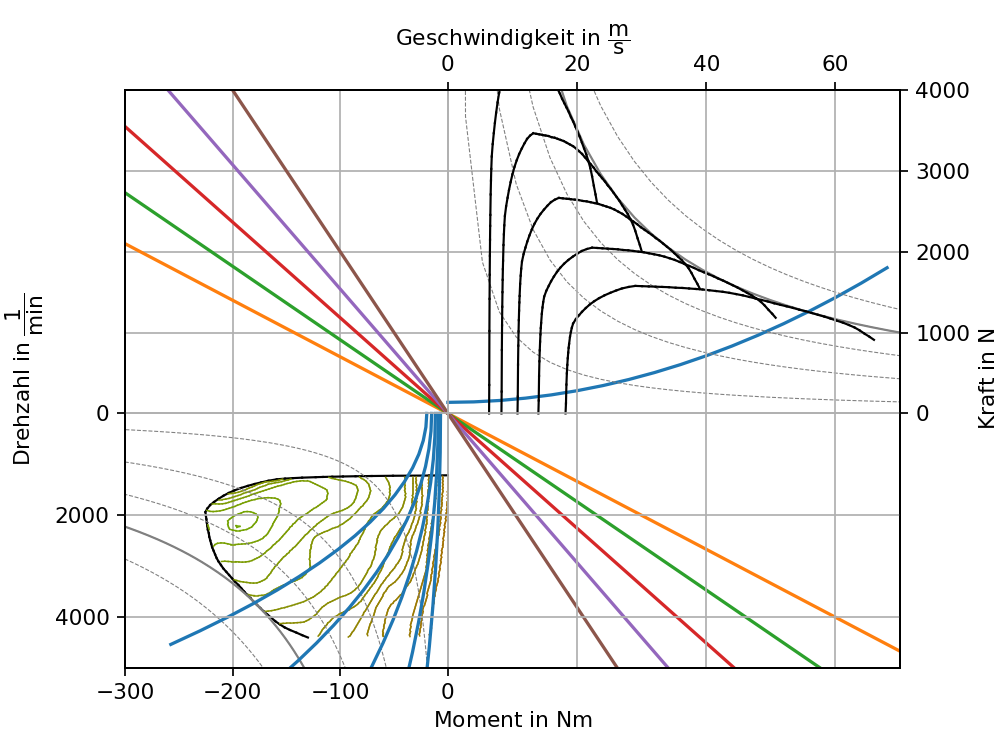

interactive(children=(Dropdown(description='Auslegung', options=('geometrisch', 'progressiv'), value='geometri…

In [20]:
def multi_gear_plot():

    fig = plt.figure()
    v=np.arange(0, 70, 4)

    grid = plt.GridSpec(2, 3, hspace=0.4, wspace=1)

    xpoints = np.arange(1, 5500, 25)*2*math.pi/60

    ax_com_us = fig.add_subplot(111) #axis complete unscaled

    create_ax(ax_com_us)
    plot_engine(ax_com_us, show_axis=False, scale=scale, quadrant=3)
    draw_resistance(ax_com_us, v, only_tot=True, scale=scale, quadrant=1)

    power = [10000, 30000, 50000, 70000, 90000]
    draw_power(ax_com_us, power, xpoints)
    draw_power(ax_com_us, [70000], xpoints, linewidth=1, linestyle='-')

    #Transmission
    xlim = 600

    iges = 7
    for _ in range(5):
        trans, = plot_scaled(ax_com_us,np.asarray((-xlim, xlim)), np.asarray((xlim*iges, -xlim*iges)))
        plot_engine(ax_com_us, show_axis=False, scale=scale, quadrant=1, i=iges, only_tor=True)
        draw_resistance(ax_com_us, v, only_tot=True, scale=scale, quadrant=3, color=cmap(0), i=iges)
        iges *= 1.3

    @widgets.interact(Auslegung = ['geometrisch', 'progressiv'])
    def change(Auslegung):
        pass
            
multi_gear_plot()